# Image Captioning 

In [1]:
import os
annotation_dir = 'Flickr8k_text'


def read_file(file_name):
    with open(os.path.join(annotation_dir, file_name), 'rb') as file_handle:
        file_lines = file_handle.read().splitlines()
    return file_lines


train_image_paths = read_file('Flickr_8k.trainImages.txt')
test_image_paths = read_file('Flickr_8k.testImages.txt')
captions = read_file('Flickr8k.token.txt')

def image_caption_map():
     image_captions={}
     for caption in captions:
        caption = caption.decode("utf-8")
        image_name = caption.split('#')[0]
        image_caption = caption.split('#')[1].split('\t')[1]
        if image_name not in image_captions.keys():
            image_captions[image_name] = [image_caption]
     return image_captions

image_captions=image_caption_map()
print(len(image_captions))
    


8091


In [2]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Subset

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import random_split

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\urja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
class Vocab(object):
    def __init__(self):
        self.w2i={}
        self.i2w={}
        self.index=0
    def __call__(self,token):
        if not token in self.w2i:
            return self.w2i['<ukn>']
        return self.w2i[token]
    def __len__(self):
        return len(self.w2i)
    def add_token(self,token):
        if token not in self.w2i:
            self.w2i[token]=self.index
            self.i2w[self.index]=token
            self.index+=1
def build_vocabulary(map):
    counter=Counter()
    ids=map.keys()
    for i,id in enumerate(ids):
        captions=map[id]
        for caption in captions:
            print(caption)
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
    tokens = [token for token, cnt in counter.items()]
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

vocab = build_vocabulary(image_captions)
vocab_path = './vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))      

A child in a pink dress is climbing up a set of stairs in an entry way .
A black dog and a spotted dog are fighting
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A man lays on a bench while his dog sits by him .
A man in an orange hat starring at something .
A child playing on a rope net .
A black and white dog is running in a grassy garden surrounded by a white fence .
A dog shakes its head near the shore , a red ball next to it .
A boy smiles in front of a stony wall in a city .
A black dog leaps over a log .
A brown and white dog is running through the snow .
A man in a hat is displaying pictures next to a skier in a blue hat .
A collage of one person climbing a cliff .
A brown dog chases the water from a sprinkler on a lawn .
A dog prepares to catch a thrown object in a field with nearby cars .
a black and white dog jumping in the air to get a toy .
A child and a woman are at waters edge in a big city .
A couple and an infant , being h

A broken down hummer gets towed on a truck bed .
The girl in the white shirt has a bracelet on and has her arm around the girl in the peach shirt .
A large man is wearing a headband with mistletoe attached to it .
A dog running with a newspaper in its mouth .
three black dogs are swimming through some murky brown water , one with a yellow object in its mouth .
A girl in a hooded jacket presents a cake with candles .
A brown dog is walking in the water .
A hiker with two hiking poles stands on a hillside with a view of the city below him .
A hiker is ready to take on a rugged outdoor trail .
A man in a hat with long sleeves and long pants stands overlooking a city .
A woman , a little boy , and a tiny baby are standing in front of a cow statue .
A man in a green hat is someplace up high .
A woman and man in winter gear stand .
A boy wearing black walks down the street with his hands in fists .
the boy laying face down on a skateboard is being pushed along the ground by another boy .
Dog

One boy rides a tricycle while another walks beside him .
A black dog bites at a stream of water on the grass .
A man hands out fliers while wearing a mask .
A black and white dog catc
a couple riding a bike
A man in a gray shirt jumps in the air .
Two black and brown dobermans running in a field playing ball .
A boy skateboards up a concrete ramp .
A boy sleeps in a hospital bed while wearing a cast on his arm .
A child in green shoes is splashing in a puddle .
A girl is peeking in a window .
A group of people gather for a picture while a woman stands on a post and takes the picture .
A brown dog chasing a yellow toy .
A child in a bright blue sweatshirt playing in the woods with a red wagon .
A child in an orange shirt holding a baseball bat watches the ball thrown at him .
A black and white agility dog weaving between poles .
A crowd of people are socializing .
A blurry dog inside on a carpet .
a group of muzzled greyhound dogs jumping over a wall .
a black and white dog running thr

A group of hip young people walk down the street in a residential neighborhood .
An athlete performs the high jump .
A man and two children in a boat on the water .
A group of people are laying in the grass under an umbrella .
Two females in skirts walking on the sidewalk .
A woman in a black dress crouching in front of a brick wall talking on a cellphone .
A man in sunglasses is writing on a pad with his bike leaned up against him .
A bearded man with a Mohawk and skull bandanna .
A couple are holding hands next to a very large mirror outdoors .
A black and white dog jumps over a hurdle .
A dog completing a fitness excercise
A girl stands on a surfboard which a man is standing behind and holding .
A brown dog is running across the grass with a stick in its mouth .
A bird is splashing in the water next to the swimming dog wearing the blue collar .
A group of people are ice skating in a big city .
A man is skating on a rail .
A dirty tan dog rolling in the dirt and looking right at the 

Three brown dogs on the patchy grass .
A football game is played .
two children in swimsuits stand talking in a lake in the woods .
A BMX biker performing a wall-ride on a ramp .
A bald person in green clothing stands in front of a brick wall .
A breakdancer is standing on one hand with a look of excitement
A man is climbing the mountain .
A boy and girl in swimwear and arm floaters
A jockey on a black horse jumps over a hurdle .
A man floating in the ocean .
A female tennis player swings for the ball .
two black dogs running down either side of a paved pathway
A man in a suit waits for the subway
A black and tan dog rolls on his back in a field .
a black dog with a blue tag running on a beach
A huge brown dog is about to attack a medium sized fluffy dog .
A boy is walking on a floor covered in graffiti .
a couple of rugby players jumping in the air to get the ball .
A group of men struggle to catch the ball in the air .
A car with white smoke trailing behind it on a black topped surfa

A person on a snowboard crosses a makeshift wooden bridge .
A man in a blue jacket is changing the performance information board of a theater .
A golden dog passes a blue ball to another golden dog on the beach .
A man and a woman sitting on camp chairs and laughing .
A blonde woman and bald man sitting together .
A snowboarder is jumping in the air next to the ski lift .
A laughing woman in a scarf .
A mother is holding a child .
A girl wearing white polka dots and black boots walks and a woman in a blue outfit hurridly walks behind her .
a man with a damaged eye stands with a child and a woman .
A bicyclist performing a trick in midair .
A dog is walking in a tire track in the snow .
A man and a toddler look at advertisements .
A close-up picture of a man and a woman .
A girl gets off her sled in the snow .
A bearded man with glasses does a toe-touch .
Two brown dogs are playing with each other in the snow .
A masked man helps burn a flag .
A group of people are lounging at a beach .

A dancing girl performs a high kick in a parade .
A boy jumps high on his skateboard .
Dirtbikers race on a muddy track .
A man in a red striped soccer shirt heads a ball .
A black and white bird getting ready to land on the water .
A dog carrying a stick in its mouth runs through a snow-covered field .
A brown and white dog is running up a grassy hill .
A bicycle rider takes a daring jump as his friends watch .
A young girl in jeans is standing on a tree limb posing for the camera .
A brown dog is running and looking up at the sky .
A man in a burnt red shirt carrying a shoulder bag walking along a city street .
two dancers each wearing black outfits with battons in midair
A girl bends over backwards in the tall grass .
A black dog fetches a large stick out of the water .
A black and white dog is running on the beach .
a soccer player kicking a goal in
a lone skier skiing down a snowy mountain on one ski .
a brown dog running through the dirty muddy grass
A game of hockey is being pla

two young children standing outside on a dirt road .
a group of dogs playing
A woman and a young girl pose and smile for a photo .
A woman taking a photo standing next to a tall man and in front of another man who is also taking a photo .
A man holding a sign with a dog on a leash .
A black dog is carrying a red bucket in its mouth .
A man and a woman holding two young boys are sitting on a park bench , posing for a photograph .
A male does an open leg trick while doing a wheelie on his bike .
A man in a tutu waterskies in a lake surrounded by snow .
A BMX biker performing a trick in midair over a dirt course .
A group of people sitting around a desk .
A girl , in a black shirt and hot pink pants , is about to hit a tennis ball on the court .
A boy on a skateboard is riding on a slope .
A motorcyclist on a green bike is airborne .
A man riding a skateboard jumps up on a wood ledge .
A bicyclist is attempting a trick while wearing minimal protective gear .
Joggers running down a rural r

A girl in pink and yellow on a pink and orange surfboard cuts through the wave .
Couple sitting on bench in front of a water fountain .
A boy is outside jumping over a flower bush on a skateboard .
A dock over water with a palm tree at the end and five boats , during twilight .
A black and white dog is going through an obstacle course .
A guy in a red jacket is snowboarding in midair .
A man playing bagpipes .
A black dog is jumping out of water .
A young boy wearing a red shirt runs along a gravel road .
A baby boy cries while sitting in the grass at the park .
A bike rider flipping over a black ramp .
A boy is making a huge splash in a paddling pool .
A girl in a pink dress in midair over a large yellow object .
Two children and a black dog are playing out in the snow .
A black dog jumping into a lake .
A boy holds a green apple in his mouth .
Lacrosse players struggling for control of the ball .
A person in a hoodie and red cap holding pizza and root beer advertisements .
a black do

A boy stands in the road wearing a big red hat .
A boy waves around a sparkler .
a blond woman wearing an apron standing in front of a bar with several empty wine glasses
A dog coming out of a large yellow tube .
A young girl has on rollerblades and looks ready to give it a try .
A little white dog runs out of a yellow tube while a man runs along clapping .
A brown dog with very floppy ears runs through a field of emerald grass .
a boy holds two sparklers .
A man in a white shirt is on his cellphone by the gate .
A boy runs near some steps .
A boy being pulled on a shovel .
A girl wets her head in a white bucket .
A boy tries to throw water on another person with his water bottle .
A child is squirted with water while older people sit and watch .
An adult and a child hold hands as they walk up a grassy hill .
A brown and black Yorkie is playing with a red ball .
A man with a baseball cap and shiny sunglasses looks down while another bald man looks down .
A girl makes an arc of water wi

In [5]:
print(vocab.w2i) #vocabulary dictionary

{'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3, 'a': 4, 'child': 5, 'in': 6, 'pink': 7, 'dress': 8, 'is': 9, 'climbing': 10, 'up': 11, 'set': 12, 'of': 13, 'stairs': 14, 'an': 15, 'entry': 16, 'way': 17, '.': 18, 'black': 19, 'dog': 20, 'and': 21, 'spotted': 22, 'are': 23, 'fighting': 24, 'little': 25, 'girl': 26, 'covered': 27, 'paint': 28, 'sits': 29, 'front': 30, 'painted': 31, 'rainbow': 32, 'with': 33, 'her': 34, 'hands': 35, 'bowl': 36, 'man': 37, 'lays': 38, 'on': 39, 'bench': 40, 'while': 41, 'his': 42, 'by': 43, 'him': 44, 'orange': 45, 'hat': 46, 'starring': 47, 'at': 48, 'something': 49, 'playing': 50, 'rope': 51, 'net': 52, 'white': 53, 'running': 54, 'grassy': 55, 'garden': 56, 'surrounded': 57, 'fence': 58, 'shakes': 59, 'its': 60, 'head': 61, 'near': 62, 'the': 63, 'shore': 64, ',': 65, 'red': 66, 'ball': 67, 'next': 68, 'to': 69, 'it': 70, 'boy': 71, 'smiles': 72, 'stony': 73, 'wall': 74, 'city': 75, 'leaps': 76, 'over': 77, 'log': 78, 'brown': 79, 'through': 80, 'sn

# Resize images

In [6]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.ANTIALIAS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)

image_path = './Flicker8k_Images/'
output_path = './resized_images/'
image_shape = [224, 224]
reshape_images(image_path, output_path, image_shape)

# Data Loader

In [41]:
class CustomFlickerDataset(data.Dataset):
    def __init__(self,data_path,map, vocabulary,transform=None):
        self.root = data_path
        self.indices = list(map.keys())
        self.vocabulary = vocabulary
        self.transform = transform
        self.map=map
    
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        vocabulary = self.vocabulary
        id = self.indices[idx]
        captions = self.map[id] 
        image = Image.open(os.path.join(self.root,id)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        caption = []
        caption.append(vocabulary('<start>'))
        for cap in captions:
         word_tokens = nltk.tokenize.word_tokenize(str(cap).lower())
         caption.extend([vocabulary(token) for token in word_tokens])       
        
        caption.append(vocabulary('<end>'))
        image_caption = torch.Tensor(caption)
        return image,image_caption
 
    def __len__(self):
        return len(self.indices)
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch) #unzipping
  
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 224, 224)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 224, 224)
    imgs = torch.stack(imgs, 0) #add dimension at 0 index
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long() #make target caption vector of same length
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens
 
def get_loader(data_path, map, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom flicker dataset."""
    # flicker caption dataset
    flicker_dataset = CustomFlickerDataset(data_path=data_path,map=map,
                       vocabulary=vocabulary,transform=transform)
        
    train_ds, test_ds = random_split(flicker_dataset,
                                               [7091,1000])
    
    # Data loader for flicker dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    train_data_loader = torch.utils.data.DataLoader(dataset=train_ds, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    test_data_loader = torch.utils.data.DataLoader(dataset=test_ds, 
                                              batch_size=1,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return train_data_loader,test_data_loader

# Models

In [8]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) 
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)   # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

# Training

In [25]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('./models_dir/'):
    os.makedirs('./models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('./vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
train_data_loader,test_data_loader = get_loader('resized_images', image_captions, vocabulary, 
                         transform, 128,shuffle=True, num_workers=0) 


# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device) 
 
    
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(train_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(train_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0] 
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item())) 
 
# Save the model checkpoints
torch.save(decoder_model.state_dict(), os.path.join(
    'models_dir/', 'decoder-{}.ckpt'.format(epoch+1)))
torch.save(encoder_model.state_dict(), os.path.join(
    'models_dir/', 'encoder-{}.ckpt'.format(epoch+1)))

Epoch [0/5], Step [0/48], Loss: 8.4248
Epoch [0/5], Step [10/48], Loss: 5.3065
Epoch [0/5], Step [20/48], Loss: 4.7904
Epoch [0/5], Step [30/48], Loss: 4.3617
Epoch [0/5], Step [40/48], Loss: 4.0588
Epoch [1/5], Step [0/48], Loss: 3.9628
Epoch [1/5], Step [10/48], Loss: 3.7545
Epoch [1/5], Step [20/48], Loss: 3.6227
Epoch [1/5], Step [30/48], Loss: 3.5433
Epoch [1/5], Step [40/48], Loss: 3.4104
Epoch [2/5], Step [0/48], Loss: 3.2605
Epoch [2/5], Step [10/48], Loss: 3.2821
Epoch [2/5], Step [20/48], Loss: 3.3416
Epoch [2/5], Step [30/48], Loss: 3.2353
Epoch [2/5], Step [40/48], Loss: 3.1582
Epoch [3/5], Step [0/48], Loss: 3.1112
Epoch [3/5], Step [10/48], Loss: 3.1862
Epoch [3/5], Step [20/48], Loss: 3.0211
Epoch [3/5], Step [30/48], Loss: 2.9785
Epoch [3/5], Step [40/48], Loss: 2.9098
Epoch [4/5], Step [0/48], Loss: 2.9372
Epoch [4/5], Step [10/48], Loss: 2.8141
Epoch [4/5], Step [20/48], Loss: 2.8976
Epoch [4/5], Step [30/48], Loss: 2.8529
Epoch [4/5], Step [40/48], Loss: 2.8198



# Prediction BLEU score

In [47]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# Load vocabulary wrapper
with open('vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)
    
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

train_data_loader,test_data_loader = get_loader('resized_images', image_captions, vocabulary, 
                         transform, 128,shuffle=True, num_workers=0) 

# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-5.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-5.ckpt'))

candidate_corpus=[]
reference_corpus=[]

for i, (imgs, caps, lens) in enumerate(test_data_loader):
    imgs = imgs.to(device)
    # Generate an caption from the image
    feat = encoder_model(imgs)
    sampled_indices = decoder_model.sample(feat)
    sampled_indices = sampled_indices.cpu().numpy()          # (batch_size, max_seq_length)
    caps=caps.numpy()
    # Convert word_ids to words
    predicted_caption = []
    target_caption=[]
    for token_index in sampled_indices:
        for tokens in token_index:
            word = vocabulary.i2w[tokens]
            if word=='<unk>':
                continue
            if word=='<end>':
                continue
            if word == '<start>':
                continue
            if word== '.' :
                continue            
            predicted_caption.append(word)
    for token_index in caps:
        for tokens in token_index:
            word = vocabulary.i2w[tokens]
            if word=='<unk>':
                continue
            if word=='<end>':
                continue
            if word == '<start>':
                continue
            if word== '.' :
                continue 
            target_caption.append(word)
            
    candidate_corpus.append(predicted_caption)
    reference_corpus.append([target_caption])


In [48]:
from torchtext.data.metrics import bleu_score #pip install torchtext==0.9.0
print(bleu_score(candidate_corpus, reference_corpus)) #bleu score

0.05112885311245918


In [50]:
print(len(test_data_loader))

1000


In [ ]:
print(candidate_corpus)

In [46]:
print(len(reference_corpus))

2000


# Generating caption for subjective image

<start> a man in a red shirt is standing on a skateboard . <end>


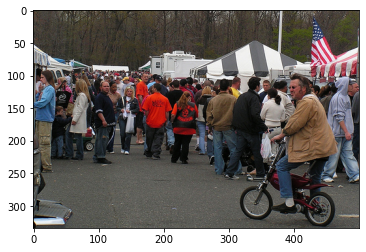

In [39]:
image_file_path = './subjective/sample2.jpg'
 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('./vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-5.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-5.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))